In [13]:
import cartopy
import time
import netCDF4 as nc
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapefile
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from global_land_mask import globe
from copy import deepcopy
from distfit import distfit
from matplotlib import pyplot as plt
from IPython.display import clear_output

pd.set_option('display.max_columns', None)

In [44]:
data = nc.Dataset('data/misc/methane-tc-2003-2021-monthly.nc')
lat = np.ma.getdata(data['latitude'][:])
lon = np.ma.getdata(data['longitude'][:])
time_nc = np.ma.getdata(data['time'][:])
years_n = int(len(time_nc) / 12)

data_nc = np.ma.getdata(data['tc_ch4'][:])
data_annual = np.full((len(lat), len(lon), years_n), np.nan, dtype = float)
for i in range(years_n):
    data_annual[:, :, i] = np.mean(data_nc[i * 12:i * 12 + 12, :, :], axis = 0)
    print(i * 12, i * 12 + 12)

print(data)

0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
96 108
108 120
120 132
132 144
144 156
156 168
168 180
180 192
192 204
204 216
216 228
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2024-01-31 17:02:46 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data6/adaptor.mars.internal-1706720565.171819-18182-5-9ae2e7f6-c5b7-4fea-beb5-c3d7f4a59c5e.nc /cache/tmp/9ae2e7f6-c5b7-4fea-beb5-c3d7f4a59c5e-adaptor.mars.internal-1706718349.7865853-18182-5-tmp.grib
    dimensions(sizes): longitude(480), latitude(241), time(228)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 tc_ch4(time, latitude, longitude)
    groups: 


In [4]:
# Regions geometries reading
step = 0.75

sf = shapefile.Reader("data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
shapes = sf.shapes()
fields = sf.fields
records = sf.records()
obj_n = len(shapes)

fieldnames = np.array([x[0] for x in fields[1:]])
admin_idx = np.where(fieldnames == 'admin')[0][0]
name_idx = np.where(fieldnames == 'name_en')[0][0]
type_idx = np.where(fieldnames == 'type_en')[0][0]
woe_idx = np.where(fieldnames == 'woe_label')[0][0]
lat_idx = np.where(fieldnames == 'latitude')[0][0]
lon_idx = np.where(fieldnames == 'longitude')[0][0]

good_idx = np.array([], dtype = int)
regions_n = 0 #len(regions)

for obj_i in range(obj_n):
    good_idx = np.append(good_idx, obj_i)
        
regions_shapes = np.array(shapes)[good_idx]
regions_records = np.array(records)[good_idx]
obj_n = len(regions_shapes)
regions_shapes_bbox = np.full((obj_n, 4), np.nan, dtype = np.single)
regions_point = np.full((obj_n, 2), np.nan, dtype = np.single)
regions_parts_n = np.zeros(obj_n, dtype = int)
for obj_i in range(obj_n):
    obj_lons = np.array([x[0] for x in regions_shapes[obj_i].points])
    obj_lons[obj_lons < 0] += 360
    obj_lats = np.array([x[1] for x in regions_shapes[obj_i].points])
    for point_i in range(len(regions_shapes[obj_i].points)):
        regions_shapes[obj_i].points[point_i] = (obj_lons[point_i], obj_lats[point_i])
    
    regions_shapes_bbox[obj_i, :] = [np.min(obj_lons), np.min(obj_lats), np.max(obj_lons), np.max(obj_lats)]
    regions_point[obj_i, :] = [regions_records[obj_i, lon_idx], regions_records[obj_i, lat_idx]]
    regions_parts_n[obj_i] = len(regions_shapes[obj_i].parts)

regions_point[regions_point[:, 0] < 0, 0] += 360
    
country_bbox = np.array([np.min(regions_shapes_bbox[:, 0]), 
                         np.min(regions_shapes_bbox[:, 1]), 
                         np.max(regions_shapes_bbox[:, 2]), 
                         np.max(regions_shapes_bbox[:, 3])])

lat_min = np.floor(country_bbox[1])
lat_max = np.ceil(country_bbox[3])
lon_min = np.floor(country_bbox[0])
lon_max = np.ceil(country_bbox[2])

lon_central = np.mean([lon_min, lon_max])
if lon_central > 180:
    lon_central -= 360

lats = lat
lons = lon
lats_n = len(lats) 
lons_n = len(lons)
max_n = len(lats) * len(lons)
# print('Regions names:', *[x + ';' for x in regions_records[:, admin_idx]])
print(f'Result: {max_n} raw points')

Result: 115680 raw points


In [12]:
# Detecting points, which lie inside of specified regions/country
start_time_all = time.time()

point_lat = np.array([], dtype = np.single)
point_lon = np.array([], dtype = np.single)
point_reg = np.array([], dtype = int)
point_regname = np.array([])

prev_progress = 0

long_lats = np.full((max_n), np.nan, dtype = np.single)
long_lons = np.full((max_n), np.nan, dtype = np.single)
for lat_i in range(lats_n):
    for lon_i in range(lons_n):
        long_lats[lat_i * lons_n + lon_i] = lats[lat_i]
        long_lons[lat_i * lons_n + lon_i] = lons[lon_i]

temp_lon = deepcopy(long_lons)
temp_lon[temp_lon > 180] -= 360
obj_idx = np.arange(obj_n)

for lat_i in range(lats_n):
    for lon_i in range(lons_n):
        cur_progress = round((lat_i * lons_n + lon_i) / (max_n - 1) * 100, 1)
        if cur_progress != prev_progress or (lat_i == 0 and lon_i == 0):
            clear_output(wait = True)
            print(f'{cur_progress} %')
            prev_progress = cur_progress

        index = lat_i * lons_n + lon_i
        if globe.is_land(long_lats[index], temp_lon[index]):
            point = Point(long_lons[index], long_lats[index])
            
            dist = np.sqrt((regions_point[:, 0] - point.x) ** 2 + (regions_point[:, 1] - point.y) ** 2)
            dist_df = pd.DataFrame({'i': obj_idx, 'dist': dist})
            obj_idx_sorted = dist_df.sort_values(by = 'dist').i.tolist()

            in_region = False            
            for obj_i in obj_idx_sorted[0:20]:
                for part_i in range(regions_parts_n[obj_i]):
                    first_idx = regions_shapes[obj_i].parts[part_i]
                    if part_i < regions_parts_n[obj_i] - 1:
                        end_idx = regions_shapes[obj_i].parts[part_i + 1]
                    else:
                        end_idx = len(regions_shapes[obj_i].points)

                    polygon = Polygon(regions_shapes[obj_i].points[first_idx:end_idx])
                    if polygon.contains(point) or polygon.touches(point):
                        in_region = True
                        break
                if in_region:
                    break

            if in_region:
                point_lat = np.append(point_lat, long_lats[index])
                point_lon = np.append(point_lon, long_lons[index])

                cur_region = regions_records[obj_i, admin_idx]
                # cur_region = regions_records[obj_i, name_idx] + ', ' + regions_records[obj_i, type_idx]

                if cur_region in point_regname:
                    point_reg = np.append(point_reg, np.where(point_regname == cur_region))
                else:
                    point_regname = np.append(point_regname, cur_region)
                    point_reg = np.append(point_reg, np.where(point_regname == cur_region))
                    
points_n = len(point_lat)
print(f'Done in {round(time.time() - start_time_all, 1)} s')
print(f'Result: {points_n} points, {len(point_regname)} regions')

100.0 %
Done in 247.5 s
Result: 26765 points, 181 regions


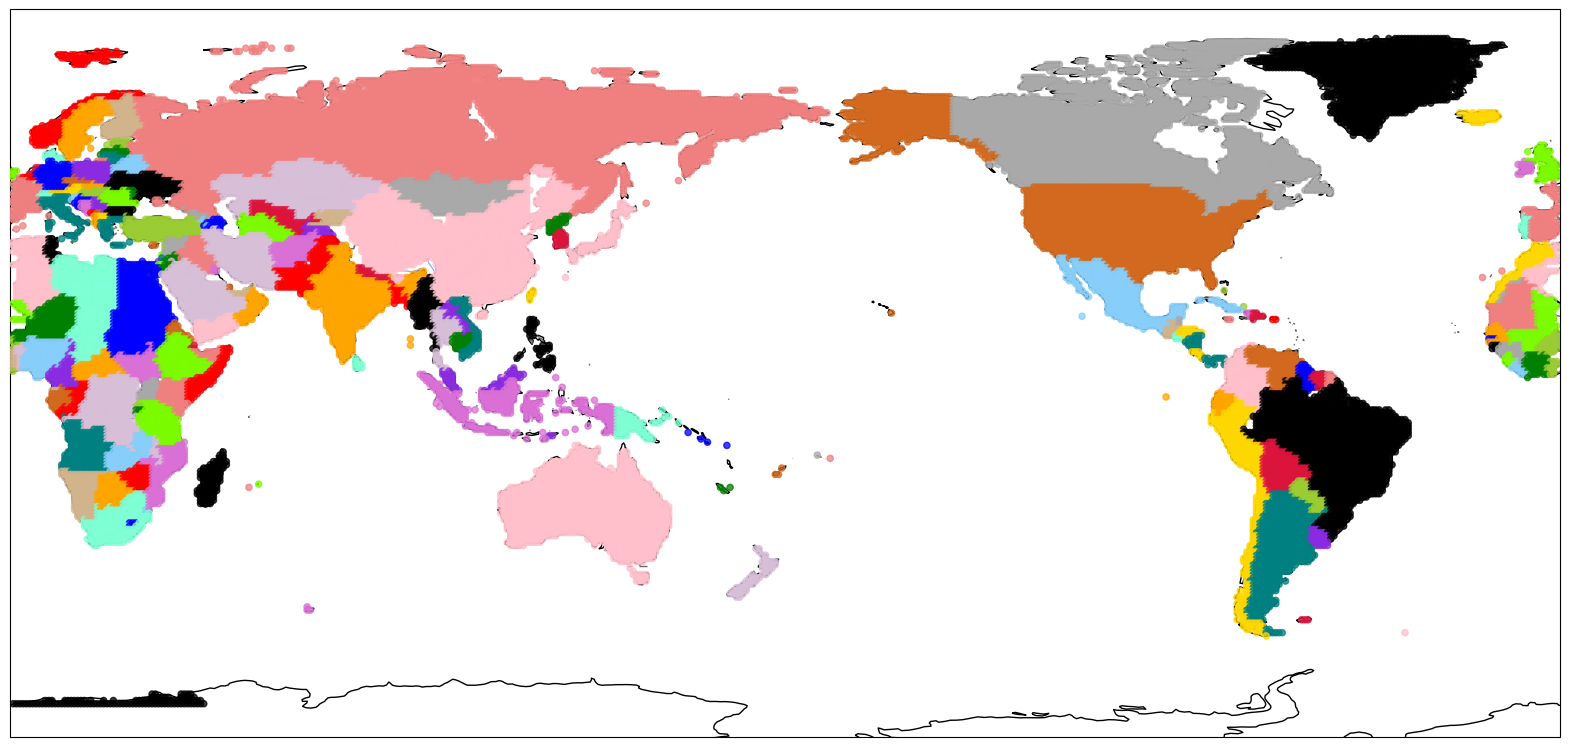

In [14]:
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

colors = ['black', 'darkgrey', 'lightcoral', 'red', 'chocolate', 
          'tan', 'orange', 'gold', 'yellowgreen', 'lawngreen', 
          'green', 'aquamarine', 'teal', 'lightskyblue', 'blue',
          'blueviolet', 'thistle', 'orchid', 'crimson', 'pink']

point_colors = []
for i in range(len(point_reg)):
    point_colors.append(colors[point_reg[i] % len(colors)])

f = plt.figure(figsize=(20, 20))
f.patch.set_facecolor('white')
data_crs = ccrs.PlateCarree(central_longitude = lon_central)
ax = plt.axes(projection=data_crs)
ax.add_feature(cartopy.feature.BORDERS, edgecolor = 'black', linewidth = 1.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.LAKES)
ax.coastlines()
ax.add_feature(states_provinces, edgecolor = 'dimgrey')
plt.scatter(point_lon - lon_central, point_lat, c = point_colors, s = 20, zorder = 10, alpha = 0.75)
plt.show()

In [30]:
len(point_lon), len(point_lat)

(26765, 26765)

In [17]:
point_regname

array(['Greenland', 'Canada', 'Russia', 'Norway',
       'United States of America', 'Finland', 'Sweden', 'Iceland',
       'Estonia', 'United Kingdom', 'Latvia', 'Denmark', 'Lithuania',
       'Belarus', 'Germany', 'Poland', 'Kazakhstan', 'Ireland',
       'Netherlands', 'China', 'Ukraine', 'Mongolia', 'France', 'Belgium',
       'Czech Republic', 'Luxembourg', 'Slovakia', 'Austria', 'Hungary',
       'Romania', 'Moldova', 'Switzerland', 'Italy', 'Slovenia',
       'Croatia', 'Republic of Serbia', 'Baykonur Cosmodrome',
       'Bosnia and Herzegovina', 'Uzbekistan', 'Japan', 'Bulgaria',
       'Georgia', 'Spain', 'Montenegro', 'Kosovo', 'Kyrgyzstan',
       'Albania', 'Macedonia', 'Turkey', 'Turkmenistan', 'North Korea',
       'Portugal', 'Greece', 'Armenia', 'Azerbaijan', 'Tajikistan',
       'Iran', 'Afghanistan', 'South Korea', 'Algeria', 'Tunisia',
       'Syria', 'Iraq', 'Pakistan', 'Northern Cyprus', 'Siachen Glacier',
       'India', 'Morocco', 'Lebanon', 'Israel', 'Jordan', '

In [29]:
np.unique(point_reg)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [32]:
reg_ids = np.unique(point_reg)

grid_ids = np.full((len(lat), len(lon)), -1, dtype = int)

for p_i in range(len(point_lat)):
    lat_i = int(np.round((90 - point_lat[p_i]) / 0.75))
    lon_i = int(point_lon[p_i] / 0.75)
    
    grid_ids[lat_i, lon_i] = point_reg[p_i]
    

In [58]:
country_n = len(reg_ids)

ch4_country_mean = np.full((country_n, years_n), np.nan, dtype = float)
ch4_country_max  = np.full((country_n, years_n), np.nan, dtype = float)

ch4_country_mean_2 = np.full((country_n), np.nan, dtype = float)
ch4_country_max_2  = np.full((country_n), np.nan, dtype = float)

for c_i in range(country_n):
    c_ids = np.where(grid_ids == reg_ids[c_i])
    
    ch4_country_mean[c_i, :] = np.mean(data_annual[c_ids[0], c_ids[1], :], axis = 0)
    ch4_country_max[c_i, :]  = np.max (data_annual[c_ids[0], c_ids[1], :], axis = 0)
    
    ch4_country_mean_2[c_i] = np.mean(data_annual[c_ids[0], c_ids[1], :], axis = (0, 1))
    ch4_country_max_2[c_i]  = np.max (data_annual[c_ids[0], c_ids[1], :], axis = (0, 1))

In [55]:
ch4_df = pd.DataFrame({'country': np.full((country_n * years_n), np.nan, dtype = object),
                       'year': np.full((country_n * years_n), -1, dtype = int),
                       'mean': np.full((country_n * years_n), np.nan, dtype = float),
                       'max':  np.full((country_n * years_n), np.nan, dtype = float)})

years = np.arange(2003, 2022)

for c_i in range(country_n):
    for y_i in range(years_n):
        index = c_i * years_n + y_i
        ch4_df.loc[index, 'country'] = point_regname[reg_ids[c_i]]
        ch4_df.loc[index, 'year']    = years[y_i]
        ch4_df.loc[index, 'mean']    = ch4_country_mean[c_i, y_i]
        ch4_df.loc[index, 'max']     = ch4_country_max[c_i, y_i]
        
ch4_df

,country,year,mean,max
0,Greenland,2003,0.007811,0.009747
1,Greenland,2004,0.007836,0.009773
2,Greenland,2005,0.007847,0.009772
3,Greenland,2006,0.007864,0.009804
4,Greenland,2007,0.007891,0.009835
...,...,...,...,...
3434,Antarctica,2017,0.008218,0.009222
3435,Antarctica,2018,0.008228,0.009229
3436,Antarctica,2019,0.008231,0.009234
3437,Antarctica,2020,0.008234,0.009237


In [59]:
ch4_df_2 = pd.DataFrame({'country': np.full((country_n), np.nan, dtype = object),
                         'mean': np.full((country_n), np.nan, dtype = float),
                         'max':  np.full((country_n), np.nan, dtype = float)})

for c_i in range(country_n):
    ch4_df_2.loc[c_i, 'country'] = point_regname[reg_ids[c_i]]
    ch4_df_2.loc[c_i, 'mean']    = ch4_country_mean_2[c_i]
    ch4_df_2.loc[c_i, 'max']     = ch4_country_max_2[c_i]
        
ch4_df_2

,country,mean,max
0,Greenland,0.007959,0.010101
1,Canada,0.009471,0.010192
2,Russia,0.009594,0.010274
3,Norway,0.009433,0.010078
4,United States of America,0.009231,0.010243
...,...,...,...
176,New Zealand,0.009263,0.009851
177,French Southern and Antarctic Lands,0.009445,0.009625
178,Falkland Islands,0.009518,0.009667
179,South Georgia and the Islands,0.009374,0.009506


In [56]:
ch4_df.to_excel('data/misc/methane-by-country-by-year.xlsx', index = False)

In [60]:
ch4_df_2.to_excel('data/misc/methane-by-country.xlsx', index = False)